# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalSWE(dsDict, obs):
    # SWE
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ex in dsDict:
        ax.plot(dsDict[ex].time, dsDict[ex].scalarSWE, label=ex)
    ax.set_ylabel('SWE (mm)')
    plt.legend(loc='best')
    
def evalSurfTemp(dsDict, obs):
    # Tsurf scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ex in dsDict:
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.', label=ex)
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlabel('Model Ts')
    ax.set_ylabel('Obs Ts')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    plt.legend(loc='best')

def evalDiurnalTs(dsDict, obs):
    # Tsurf scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    hours = np.arange(0, 24)
    for n, ex in enumerate(dsDict):
        ax.plot(hours, dsDict[ex].scalarSurfaceTemp.groupby('time.hour').mean(dim='time') - 273.15, label=ex)
    ax.plot(hours, obs.Tsrf.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($^{\circ}$)')
    plt.legend(loc='best')

## Evaluation data

In [4]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

# --------------------------------------------------------------------------------------------
# Select only the model forcing period
CDP = CDP.loc[dict(time = slice(datetime(2005, 10, 1), datetime(2006, 9, 1)))]

# --------------------------------------------------------------------------------------------
# Add bulk stability measure to each site
RiBulk,_,_ = turbpy.bulkRichardson(SWA.Tair + 273.15, SWA.Tsrf + 273.15, SWA.WIND, 6 - SWA.snowDepth)
SWA['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(SNQ.Tair + 273.15, SNQ.Tsrf + 273.15, SNQ.WIND, 6 - SNQ.snowDepth)
SNQ['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 6 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

# --------------------------------------------------------------------------------------------
# Resample to daily
dailyResample = False
if dailyResample:
    # Other accounting
    SWA_daily = SWA.resample(how='mean', freq='d', dim='time')
    SNQ_daily = SNQ.resample(how='mean', freq='d', dim='time')
    CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

    os.chdir(dirData)
    SWA_daily.to_netcdf('SWA.ModTsfc.Daily.nc')
    SNQ_daily.to_netcdf('SNQ.ModTsfc.Daily.nc')
    CDP_daily.to_netcdf('CDP.ModTsfc.Daily.nc')

# Load daily resamples
else:
    SWA_daily = xr.open_dataset('SWA.ModTsfc.Daily.nc')
    SNQ_daily = xr.open_dataset('SNQ.ModTsfc.Daily.nc')
    CDP_daily = xr.open_dataset('CDP.ModTsfc.Daily.nc')

# --------------------------------------------------------------------------------------------
# Dictionaries for iterating
met = {'SWA': SWA,
       'SNQ': SNQ,
       'CDP': CDP}

metDaily = {'SWA_daily': SWA_daily,
            'SNQ_daily': SNQ_daily,
            'CDP_daily': CDP_daily}

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive


## Forcing data

In [5]:
os.chdir(dirData)
forceCDP = xr.open_dataset('CDP.ModTsfc.ModelForcing_wy2006.nc')

## Model output

## Check out the layer runs

In [6]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/layers/CDP/')
layerThin = xr.open_dataset('layerThick_2005-2006_thinLayer_1.nc')
layerThick = xr.open_dataset('layerThin_2005-2006_thickLayer_1.nc')
jrdn1991 = xr.open_dataset('jrdn1991_2005-2006_jrdn1991_1.nc')
clm2010 = xr.open_dataset('CLM_2010_2005-2006_CLM_2010_1.nc')

layerExp = {'layerThin': layerThin,
            'layerThick': layerThick,
            'jrdn1991': jrdn1991,
            'clm2010': clm2010
           }

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for l in layerExp:
    layerExp[l]['time'] = CDP.time.values

## Check out the thermal conductivity runs

In [7]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/thermalCond/CDP/')

thCond = {}
arrayExpID = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
expIDAppend = ['Mid', 'Low', 'High']

for expID in arrayExpID:
    for append in expIDAppend:
        expName = expID + append
        thCond[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for t in thCond:
    thCond[t]['time'] = CDP.time.values

## Check out the longwave bias runs

In [8]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/longwaveBias/CDP/')

biasLW = {}
arrayExpID = ['standard', 'louisinv', 'mahrtexp']
arrayExpID = ['lowLW', 'obsLW', 'highLW']

for expID in arrayExpID:
    biasLW[expID] = xr.open_dataset(expID + '_2005-2006_' + expID + '_1.nc')

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in biasLW:
    biasLW[b]['time'] = CDP.time.values

##  Check out the turbulence stability runs

In [9]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/stability/CDP/')

stab = {}
expIDAppend = ['Low', 'Mid', 'High']
arrayExpID = ['standard', 'louisinv', 'mahrtexp']

for expID in arrayExpID:
    for append in expIDAppend:
        expName = expID + append
        stab[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in stab:
    stab[b]['time'] = CDP.time.values

## Quick check of model results

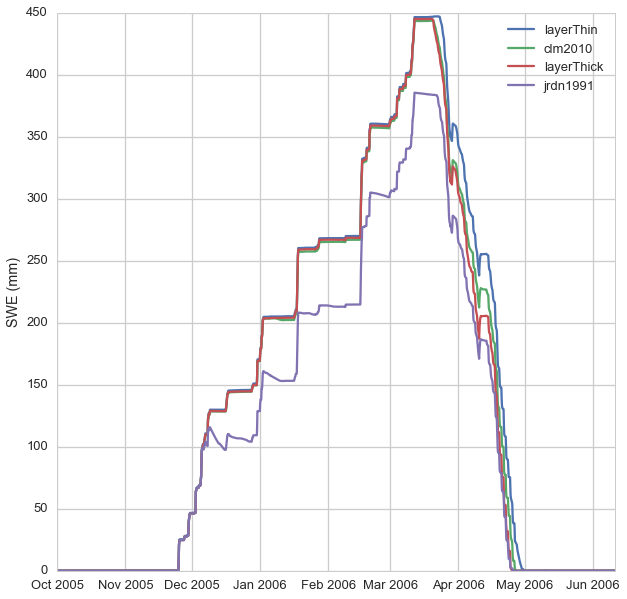

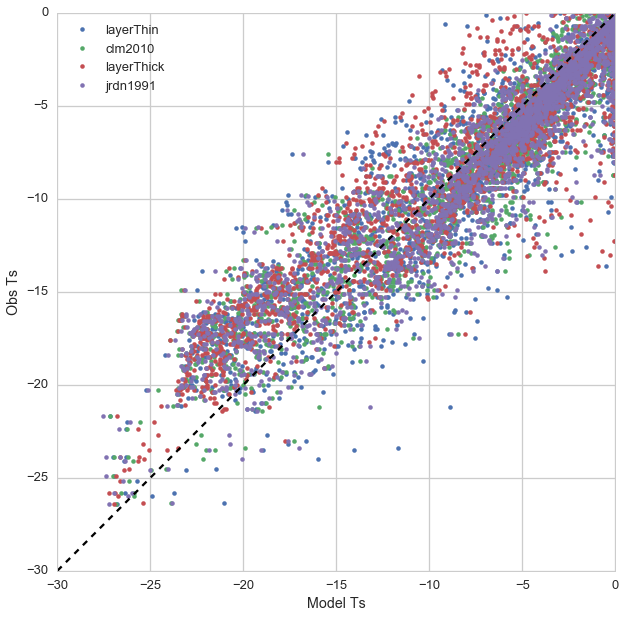

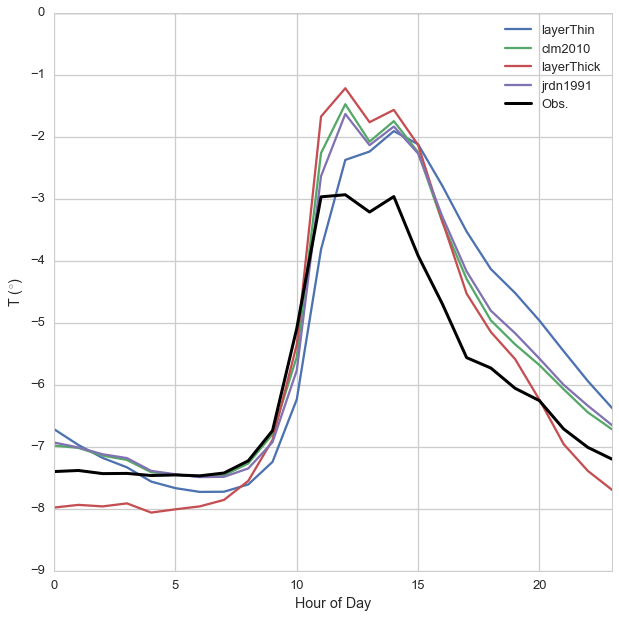

In [10]:
evalSWE(layerExp, CDP)
evalSurfTemp(layerExp, CDP)

tempDS = {}
for l in layerExp:
    tempDS[l] = layerExp[l]
    tempDS[l]['scalarSurfaceTemp'] = layerExp[l]['scalarSurfaceTemp'].where(CDP.SP)
evalDiurnalTs(tempDS, CDP)

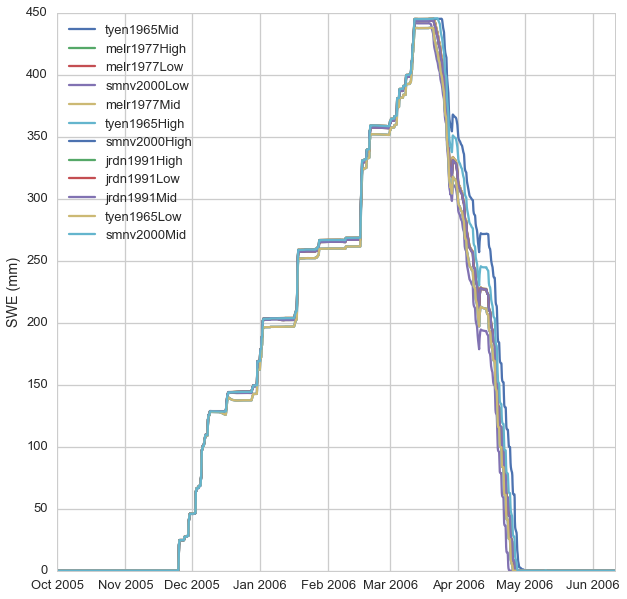

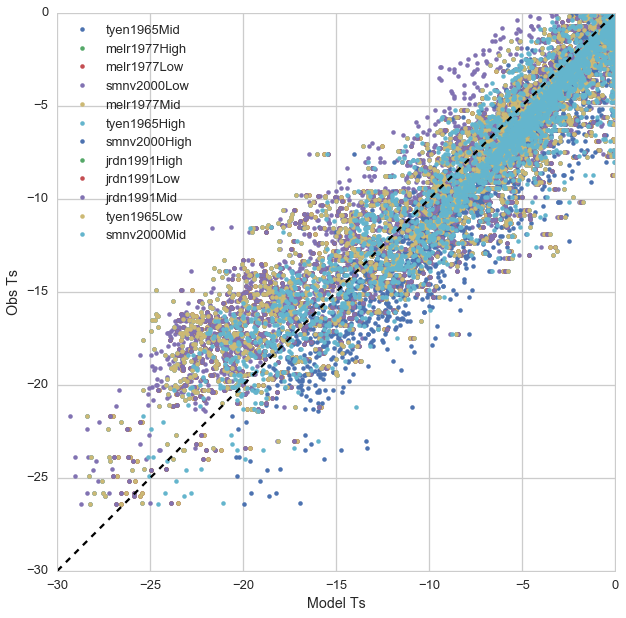

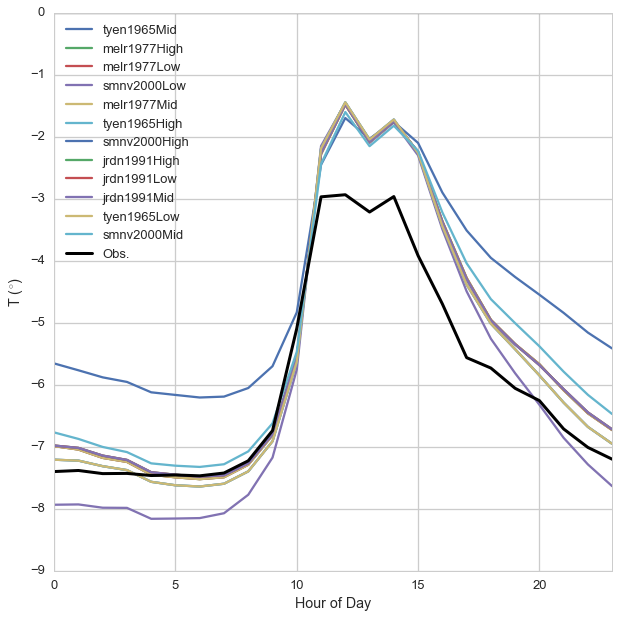

In [11]:
evalSWE(thCond, CDP)
evalSurfTemp(thCond, CDP)

tempDS = {}
for l in thCond:
    tempDS[l] = thCond[l]
    tempDS[l]['scalarSurfaceTemp'] = thCond[l]['scalarSurfaceTemp'].where(CDP.SP)
evalDiurnalTs(tempDS, CDP)

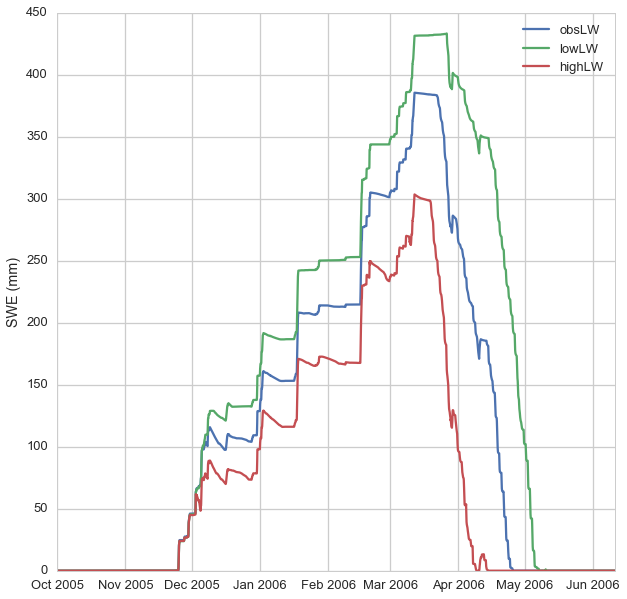

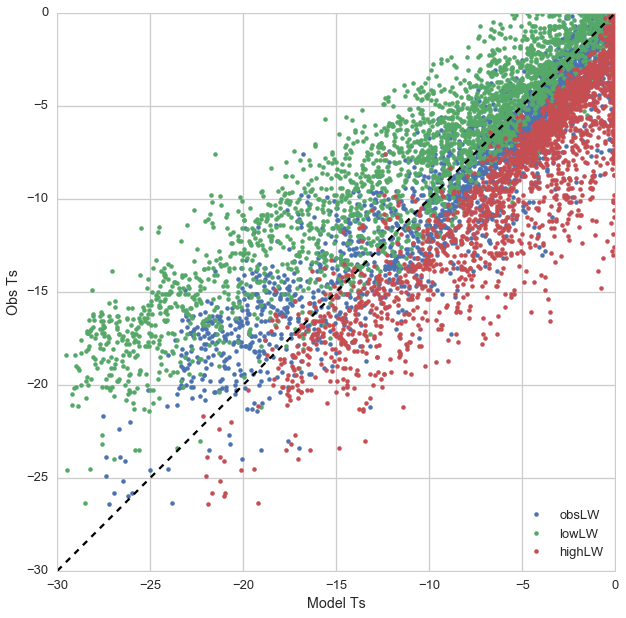

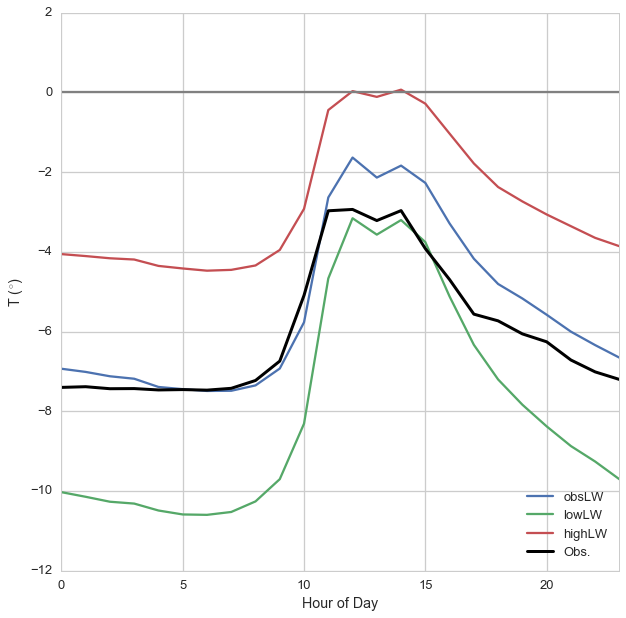

In [12]:
evalSWE(biasLW, CDP)
evalSurfTemp(biasLW, CDP)

tempDS = {}
for l in biasLW:
    tempDS[l] = biasLW[l]
    tempDS[l]['scalarSurfaceTemp'] = biasLW[l]['scalarSurfaceTemp'].where(CDP.SP)
evalDiurnalTs(tempDS, CDP)

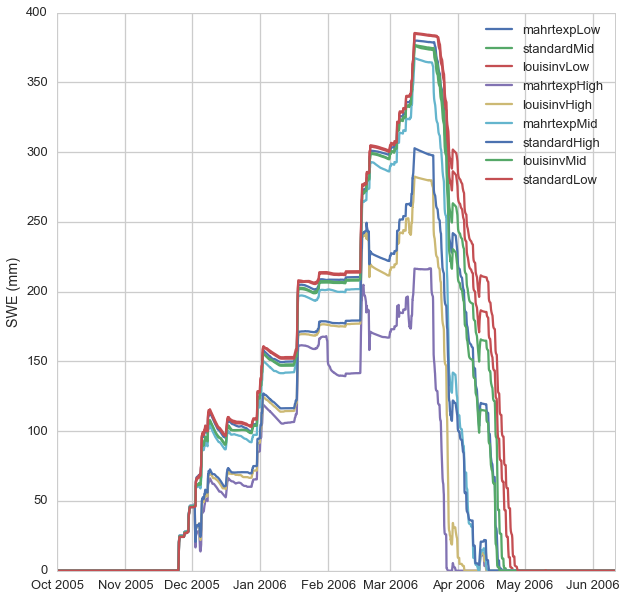

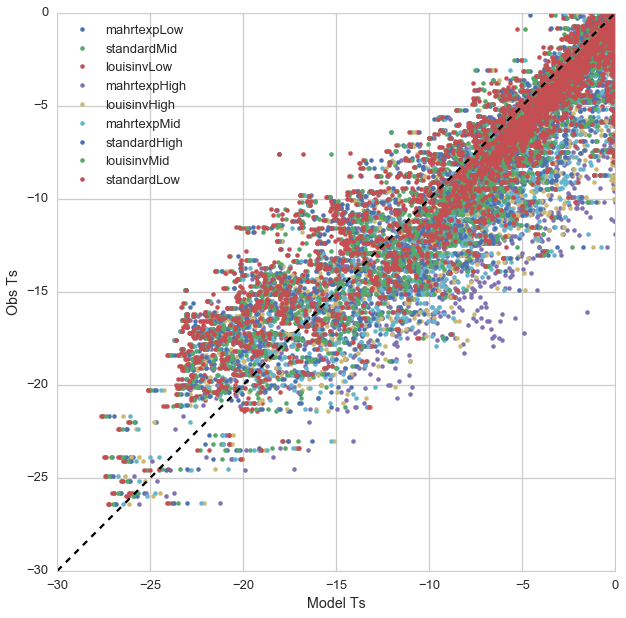

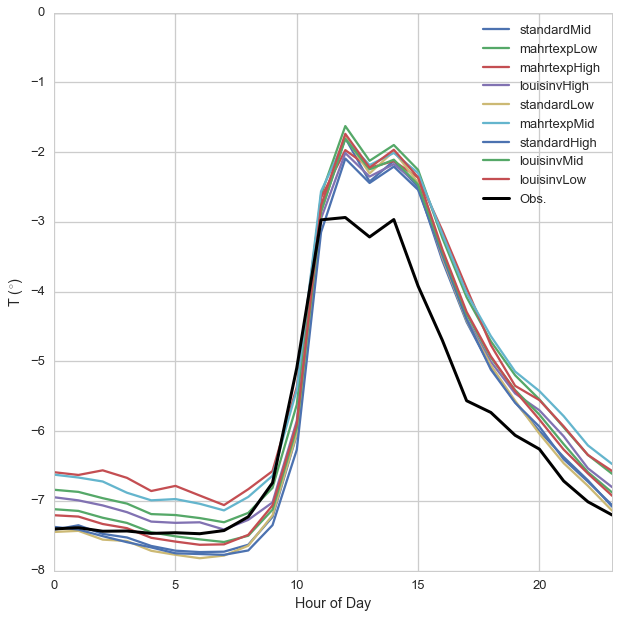

In [16]:
evalSWE(stab, CDP)
evalSurfTemp(stab, CDP)

tempDS = {}
for l in stab:
    tempDS[l] = stab[l]
    tempDS[l]['scalarSurfaceTemp'] = stab[l]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[l]['scalarSWE'] > 0))
evalDiurnalTs(tempDS, CDP)